In [9]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

dataset = pd.read_csv('/content/sample_data/al_data.csv')

print(dataset.columns)
print(dataset.info())

print(dataset.isna().sum())

X = dataset.drop(['class', 'Tensile Strength (MPa)'], axis=1)
y = dataset['Tensile Strength (MPa)']


y_imputer = SimpleImputer(strategy='mean')
y = pd.Series(y_imputer.fit_transform(y.values.reshape(-1, 1)).ravel(), name=y.name)


numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='mean'), numeric_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features)
    ])

model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

score = r2_score(y_test, y_pred)
print(f'R-squared score: {score}')

numeric_feature_names = numeric_features.tolist()
categorical_feature_names = model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features).tolist()

feature_names = numeric_feature_names + categorical_feature_names

coefficients = model.named_steps['regressor'].coef_

feature_importance = pd.DataFrame({'feature': feature_names, 'importance': coefficients})
print(feature_importance.sort_values('importance', ascending=False))

Index(['Unnamed: 0', 'Processing', 'Ag', 'Al', 'B', 'Be', 'Bi', 'Cd', 'Co',
       'Cr', 'Cu', 'Er', 'Eu', 'Fe', 'Ga', 'Li', 'Mg', 'Mn', 'Ni', 'Pb', 'Sc',
       'Si', 'Sn', 'Ti', 'V', 'Zn', 'Zr', 'Elongation (%)',
       'Tensile Strength (MPa)', 'Yield Strength (MPa)', 'class'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1154 entries, 0 to 1153
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              1154 non-null   int64  
 1   Processing              1154 non-null   object 
 2   Ag                      1154 non-null   float64
 3   Al                      1154 non-null   float64
 4   B                       1154 non-null   float64
 5   Be                      1154 non-null   float64
 6   Bi                      1154 non-null   float64
 7   Cd                      1154 non-null   float64
 8   Co                      1154 non-null   float64
 9   C

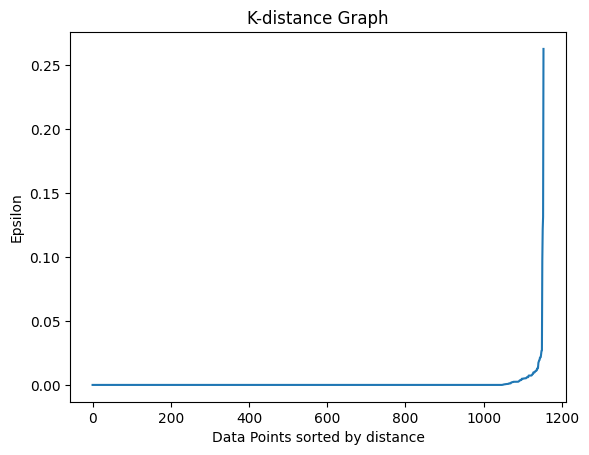

For eps=0.3, min_samples=3: silhouette score = 0.6948372650308454
For eps=0.3, min_samples=4: silhouette score = 0.6948372650308454
For eps=0.3, min_samples=5: silhouette score = 0.6948372650308454
For eps=0.5, min_samples=3: silhouette score = 0.6948372650308454
For eps=0.5, min_samples=4: silhouette score = 0.6948372650308454
For eps=0.5, min_samples=5: silhouette score = 0.6948372650308454
For eps=0.7, min_samples=3: silhouette score = 0.6948372650308454
For eps=0.7, min_samples=4: silhouette score = 0.6948372650308454
For eps=0.7, min_samples=5: silhouette score = 0.6948372650308454
Best parameters: eps=0.3, min_samples=3
Best silhouette score: 0.6948372650308454


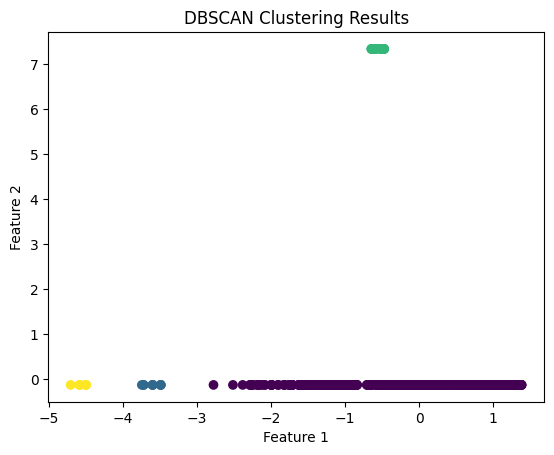

Number of clusters: 4
Number of noise points: 0


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors

dataset = pd.read_csv('/content/sample_data/al_data.csv')
X = dataset.iloc[:, [3, 4]].values

scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

def optimal_eps(data, min_samples):
    neigh = NearestNeighbors(n_neighbors=min_samples)
    nbrs = neigh.fit(data)
    distances, indices = nbrs.kneighbors(data)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    plt.plot(distances)
    plt.title('K-distance Graph')
    plt.xlabel('Data Points sorted by distance')
    plt.ylabel('Epsilon')
    plt.show()

optimal_eps(X_normalized, 4)

eps_values = [0.3, 0.5, 0.7]
min_samples_values = [3, 4, 5]

best_silhouette = -1
best_params = None

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_normalized)

        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

        if n_clusters > 1:
            silhouette_avg = silhouette_score(X_normalized, labels)
            print(f"For eps={eps}, min_samples={min_samples}: silhouette score = {silhouette_avg}")

            if silhouette_avg > best_silhouette:
                best_silhouette = silhouette_avg
                best_params = (eps, min_samples)
        else:
            print(f"For eps={eps}, min_samples={min_samples}: Only one cluster formed")

print(f"Best parameters: eps={best_params[0]}, min_samples={best_params[1]}")
print(f"Best silhouette score: {best_silhouette}")

best_model = DBSCAN(eps=best_params[0], min_samples=best_params[1])
best_labels = best_model.fit_predict(X_normalized)

plt.scatter(X_normalized[:, 0], X_normalized[:, 1], c=best_labels, cmap='viridis')
plt.title('DBSCAN Clustering Results')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

n_clusters = len(set(best_labels)) - (1 if -1 in best_labels else 0)
n_noise = list(best_labels).count(-1)
print(f'Number of clusters: {n_clusters}')
print(f'Number of noise points: {n_noise}')

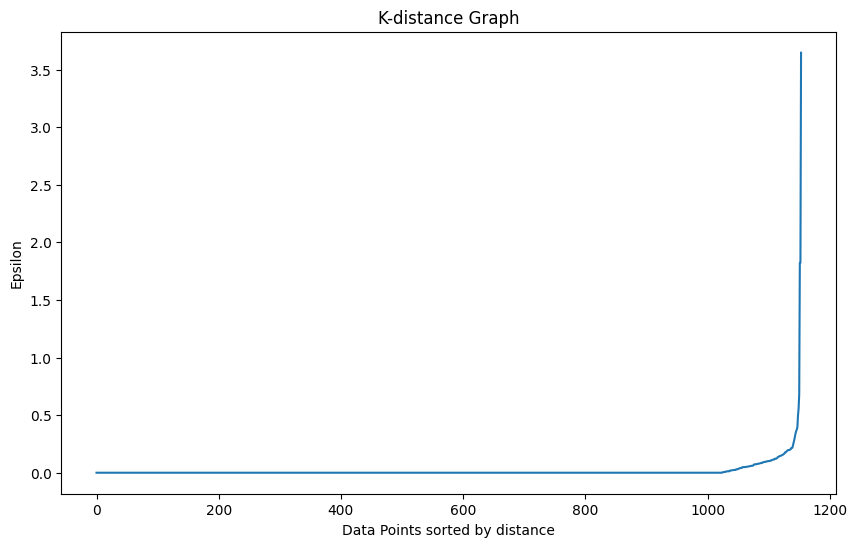

For eps=0.3, min_samples=3: silhouette score = 0.5053590568082165
For eps=0.3, min_samples=4: silhouette score = 0.4880688302661499
For eps=0.3, min_samples=5: silhouette score = 0.4784029479905874
For eps=0.5, min_samples=3: silhouette score = 0.2804729482308529
For eps=0.5, min_samples=4: silhouette score = 0.2913900023538497
For eps=0.5, min_samples=5: silhouette score = 0.30553056782986104
For eps=0.7, min_samples=3: silhouette score = 0.22112104311955127
For eps=0.7, min_samples=4: silhouette score = 0.22112104311955127
For eps=0.7, min_samples=5: silhouette score = 0.22254406568221782
Best parameters: eps=0.3, min_samples=3
Best silhouette score: 0.5053590568082165


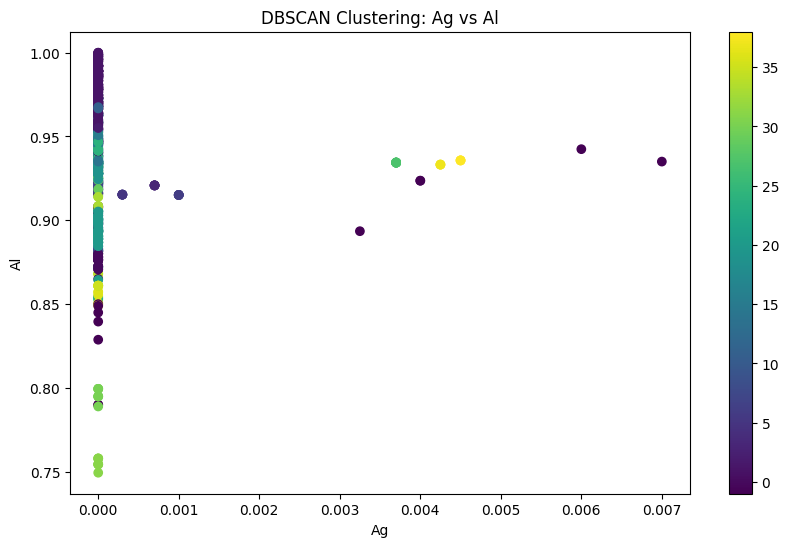

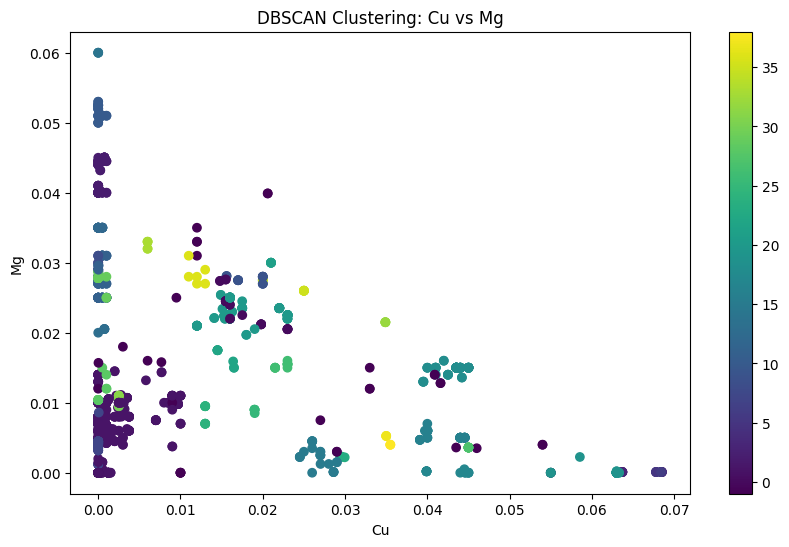

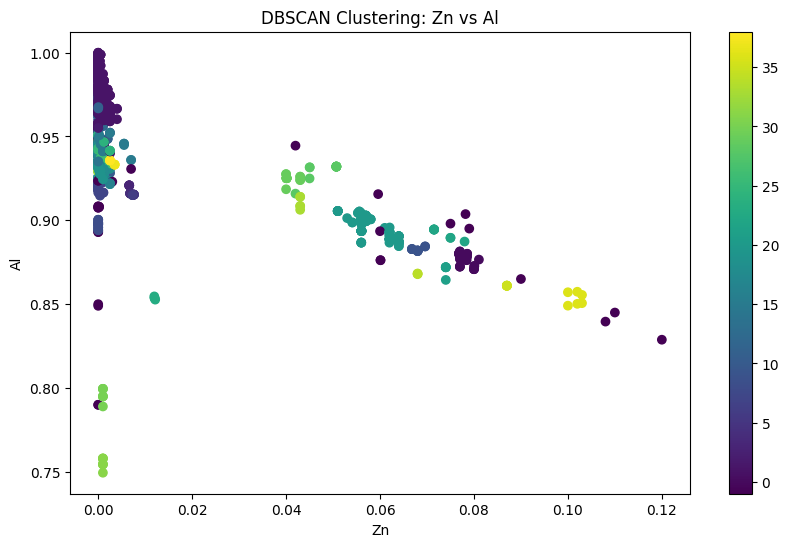

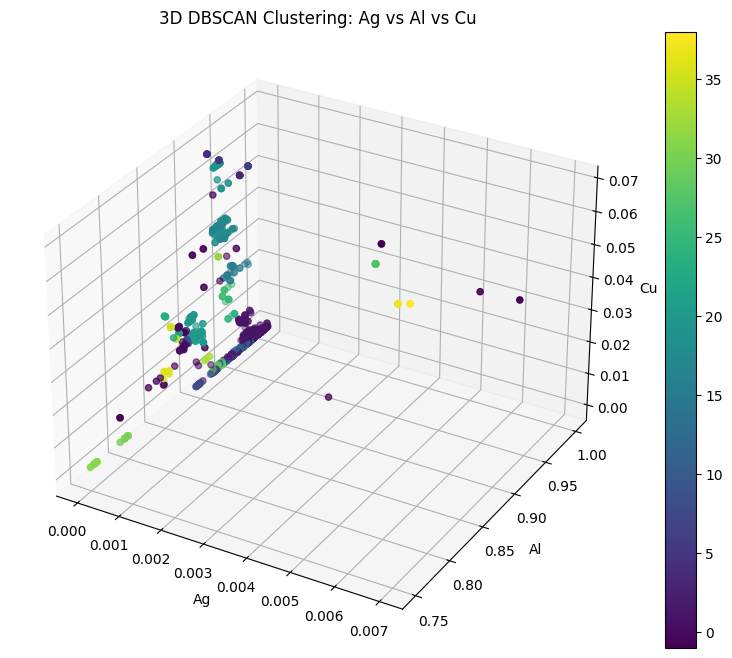

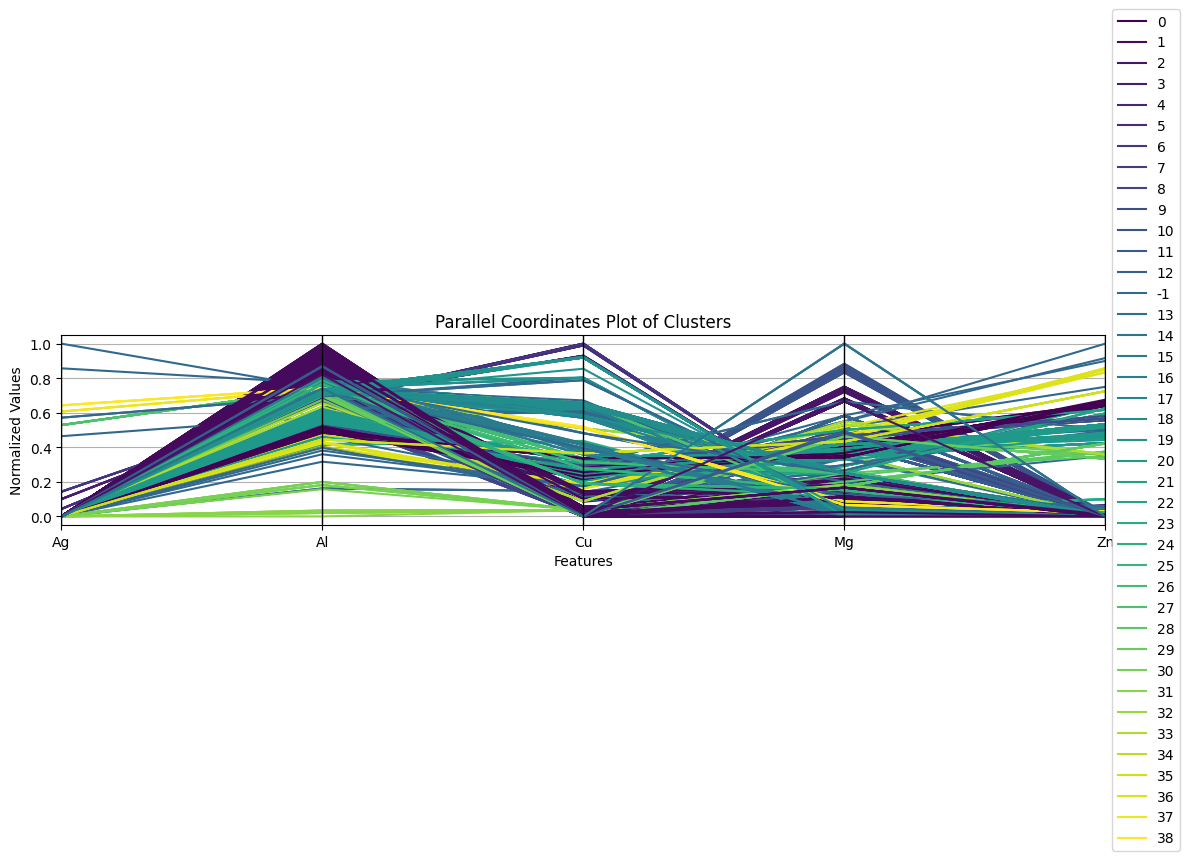

Number of clusters: 39
Number of noise points: 35

Cluster 0 characteristics:
         Ag         Al         Cu         Mg         Zn
count  28.0  28.000000  28.000000  28.000000  28.000000
mean    0.0   0.876667   0.017587   0.023285   0.078014
std     0.0   0.003416   0.002984   0.002336   0.001322
min     0.0   0.870850   0.014800   0.020500   0.076800
25%     0.0   0.872742   0.015508   0.021200   0.077000
50%     0.0   0.877430   0.016000   0.023257   0.077235
75%     0.0   0.880028   0.019800   0.024517   0.078547
max     0.0   0.881400   0.023020   0.027600   0.081053

Cluster 1 characteristics:
          Ag          Al          Cu          Mg          Zn
count  421.0  421.000000  421.000000  421.000000  421.000000
mean     0.0    0.981254    0.001516    0.005977    0.000425
std      0.0    0.010902    0.002472    0.004160    0.000739
min      0.0    0.957000    0.000000    0.000000    0.000000
25%      0.0    0.972472    0.000000    0.000300    0.000000
50%      0.0    0.983000

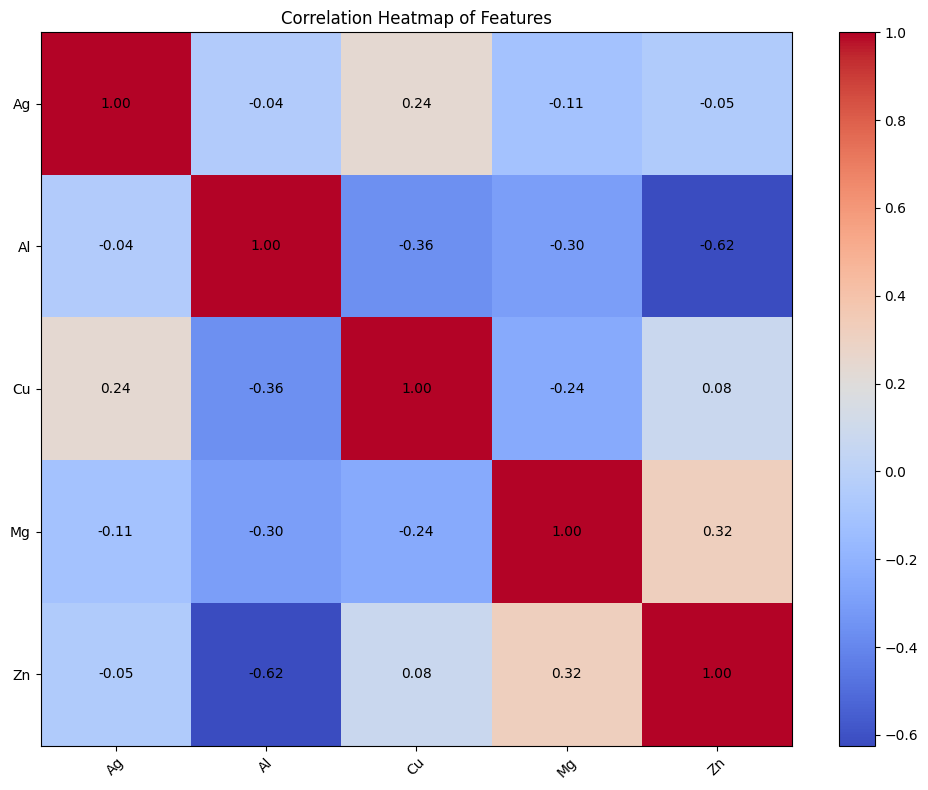

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from mpl_toolkits.mplot3d import Axes3D

dataset = pd.read_csv('/content/sample_data/al_data.csv')

features = ['Ag', 'Al', 'Cu', 'Mg', 'Zn']
X = dataset[features]

scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

def optimal_eps(data, min_samples):
    neigh = NearestNeighbors(n_neighbors=min_samples)
    nbrs = neigh.fit(data)
    distances, indices = nbrs.kneighbors(data)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    plt.figure(figsize=(10, 6))
    plt.plot(distances)
    plt.title('K-distance Graph')
    plt.xlabel('Data Points sorted by distance')
    plt.ylabel('Epsilon')
    plt.show()

optimal_eps(X_normalized, 4)

eps_values = [0.3, 0.5, 0.7]
min_samples_values = [3, 4, 5]

best_silhouette = -1
best_params = None

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_normalized)

        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

        if n_clusters > 1:
            silhouette_avg = silhouette_score(X_normalized, labels)
            print(f"For eps={eps}, min_samples={min_samples}: silhouette score = {silhouette_avg}")

            if silhouette_avg > best_silhouette:
                best_silhouette = silhouette_avg
                best_params = (eps, min_samples)
        else:
            print(f"For eps={eps}, min_samples={min_samples}: Only one cluster formed")

print(f"Best parameters: eps={best_params[0]}, min_samples={best_params[1]}")
print(f"Best silhouette score: {best_silhouette}")

best_model = DBSCAN(eps=best_params[0], min_samples=best_params[1])
best_labels = best_model.fit_predict(X_normalized)

def plot_scatter(x, y, labels, title):
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(x, y, c=labels, cmap='viridis')
    plt.colorbar(scatter)
    plt.title(title)
    plt.xlabel(x.name)
    plt.ylabel(y.name)
    plt.show()

plot_scatter(X['Ag'], X['Al'], best_labels, 'DBSCAN Clustering: Ag vs Al')
plot_scatter(X['Cu'], X['Mg'], best_labels, 'DBSCAN Clustering: Cu vs Mg')
plot_scatter(X['Zn'], X['Al'], best_labels, 'DBSCAN Clustering: Zn vs Al')

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X['Ag'], X['Al'], X['Cu'], c=best_labels, cmap='viridis')
ax.set_xlabel('Ag')
ax.set_ylabel('Al')
ax.set_zlabel('Cu')
plt.colorbar(scatter)
plt.title('3D DBSCAN Clustering: Ag vs Al vs Cu')
plt.show()

from pandas.plotting import parallel_coordinates

X_norm = (X - X.min()) / (X.max() - X.min())
X_norm['Cluster'] = best_labels

plt.figure(figsize=(12, 6))
parallel_coordinates(X_norm, 'Cluster', colormap='viridis')
plt.title('Parallel Coordinates Plot of Clusters')
plt.xlabel('Features')
plt.ylabel('Normalized Values')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

n_clusters = len(set(best_labels)) - (1 if -1 in best_labels else 0)
n_noise = list(best_labels).count(-1)
print(f'Number of clusters: {n_clusters}')
print(f'Number of noise points: {n_noise}')

for cluster in range(n_clusters):
    cluster_points = X[best_labels == cluster]
    print(f"\nCluster {cluster} characteristics:")
    print(cluster_points.describe())

plt.figure(figsize=(10, 8))
correlation_matrix = X.corr()
plt.imshow(correlation_matrix, cmap='coolwarm', aspect='auto')
plt.colorbar()
plt.xticks(range(len(X.columns)), X.columns, rotation=45)
plt.yticks(range(len(X.columns)), X.columns)
plt.title('Correlation Heatmap of Features')
for i in range(len(X.columns)):
    for j in range(len(X.columns)):
        plt.text(j, i, f"{correlation_matrix.iloc[i, j]:.2f}", ha='center', va='center')
plt.tight_layout()
plt.show()